In [2]:

%matplotlib inline
import pandas as pd
import numpy as np
# vectorizer
from sklearn.feature_extraction.text import CountVectorizer,HashingVectorizer,TfidfVectorizer,TfidfTransformer
# our classifiers
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier,RidgeClassifier
from sklearn.linear_model import Perceptron

import os,codecs
import nltk
import string
from nltk.corpus import stopwords

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

import re

In [3]:
baseDirectory = "./"

trainingDir = baseDirectory + "20news-bydate-train/"
testDir = baseDirectory + "20news-bydate-test/"

categories = os.listdir(trainingDir)
categories = [filename for filename in categories
                           if os.path.isdir(trainingDir + filename)]
categories = ['comp.graphics','rec.sport.baseball','sci.med','soc.religion.christian']

In [4]:
def strip_header(text):

    before, blankline, after = text.partition('\n\n')
    return after

In [64]:
def stop_word(text):
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords += string.lowercase[:]   
    content = [w for w in text if w not in stopwords]
    return content

In [65]:
def make_xy(dir, categories):
    X=[]
    Y=[]
    filesPerCat={}
    fileStats =[]
    for ind,category in enumerate(categories):
        currentdir = dir + category
        files = os.listdir(currentdir)
        filesPerCat[category] = len(files)
        for file in files:
            f = codecs.open(currentdir + '/' + file, 'r', 'iso8859-1')
            content = f.read().lower()      
        
            sen = nltk.tokenize.sent_tokenize(content)   
            #sen_no_punctuation = re.sub("[^a-zA-Z]"," ", str(sen))
            sen_no_punctuation = str(sen).translate(None,string.punctuation)
           
            tokens_no_sw = stop_word(nltk.tokenize.word_tokenize(sen_no_punctuation)) 
                     
            X.append(' '.join(tokens_no_sw))
            #X.append(content)
            Y.append(ind)
            
            fileStats.append([len(sen),len(tokens_no_sw)])
            
    return X,Y,filesPerCat,fileStats 

In [66]:
X_train_data,Y_train_data,trainFilesPerCat,trainFileStats = make_xy(trainingDir, categories)
X_test_data,Y_test_data, testFilesPerCat,testFileStats  = make_xy(testDir, categories)

vectorizer = TfidfVectorizer(stop_words = 'english',min_df=5)
#vectorizer = TfidfVectorizer(max_df=0.5,sublinear_tf=True,stop_words='english',min_df=5)
X_train = vectorizer.fit_transform(X_train_data)
X_test = vectorizer.transform(X_test_data)

Y_train =np.array(Y_train_data)
Y_test = np.array(Y_test_data)


In [80]:

X_train

<2374x8521 sparse matrix of type '<type 'numpy.float64'>'
	with 183053 stored elements in Compressed Sparse Row format>

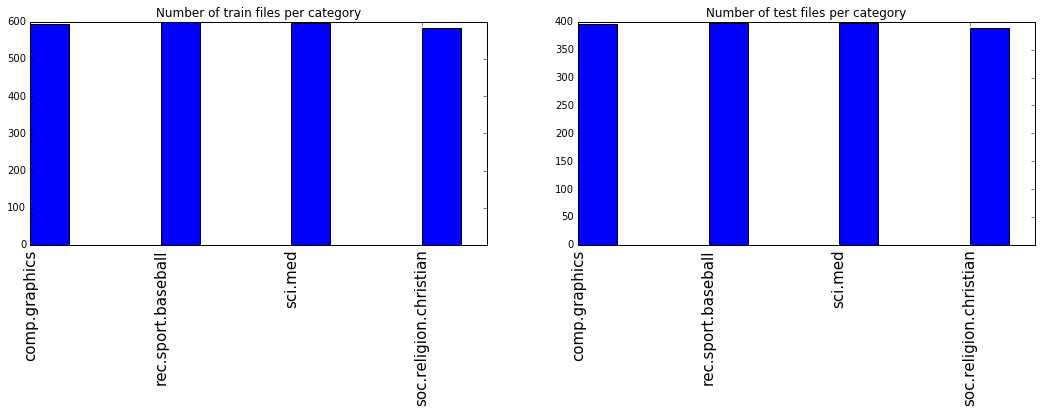

In [68]:
fig,axes = plt.subplots(1,2 ,figsize = (18,4))

plt.axes(axes[0])
x= range(len(categories))
y = trainFilesPerCat.values()
plt.bar(x,y,width=0.3,alpha=1)
axes[0].set_xticks(x)
plt.setp(axes[0].set_xticklabels(categories),rotation=90,fontsize=15)
axes[0].set_title('Number of train files per category')

plt.axes(axes[1])
y = testFilesPerCat.values()
plt.bar(x,y,width= 0.3)
axes[1].set_xticks(x)
plt.setp(axes[1].set_xticklabels(categories),rotation=90,fontsize=15)
axes[1].set_title('Number of test files per category')
plt.show()

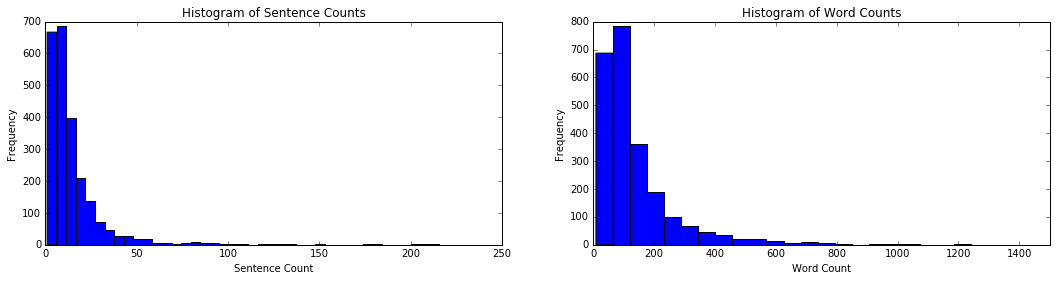

Max word count: 5613 Min word count: 9 Median word count: 96.0


In [69]:
#Histogram of Sentence counts
trainFileStats = pd.DataFrame(trainFileStats)  
sentencesPerFile = trainFileStats[0]
wordsPerFile = trainFileStats[1]
fig,axes = plt.subplots(1,2,figsize = (18,4))

plt.axes(axes[0])
plt.hist(sentencesPerFile,bins=100)
axes[0].set_xlim([0,250])
axes[0].set_xlabel('Sentence Count')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of Sentence Counts')

plt.axes(axes[1])
plt.hist(wordsPerFile,bins=100)
axes[1].set_xlim([0,1500])
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of Word Counts')
plt.show()
print 'Max word count:',np.max(wordsPerFile),'Min word count:',np.min(wordsPerFile),'Median word count:',np.median(wordsPerFile)


In [70]:
tdict={}
for i in range(len(X_train_data)):
    tokens = X_train_data[i].split()
    for t in tokens:
       
            if t not in tdict:
                tdict[t] = 1
            else:
                tdict[t] = tdict[t] + 1
word_count = pd.DataFrame.from_dict(tdict,orient='index')       
word_count.columns = ['count']
word_count = word_count.sort_values('count',ascending=False)

word_count.shape        

(73534, 1)

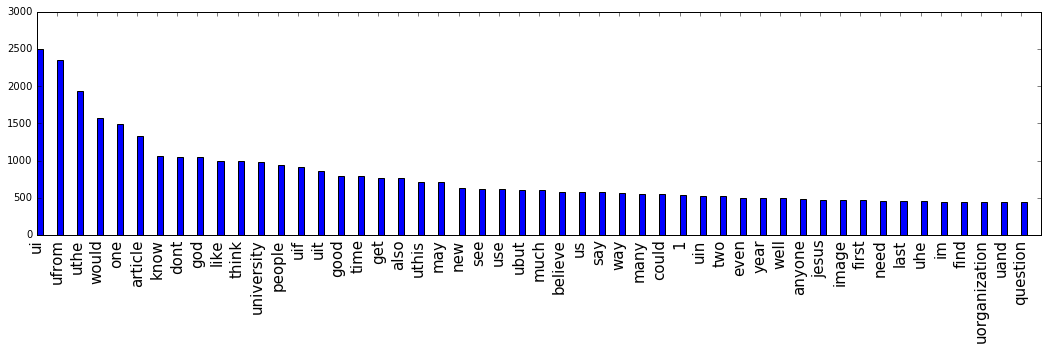

In [71]:
#Potting the top 50 word counts

x = range(50)
y = word_count.head(50)['count']

fig,axes = plt.subplots(1,figsize = (18,4))
plt.bar(x,y,width= 0.3)
axes.set_xticks(x)
xtickname = axes.set_xticklabels(word_count.index[0:50])
plt.setp(xtickname,rotation = 90,fontsize = 15)
plt.show()

In [72]:
#Becnhmark classifier
clf = MultinomialNB().fit(X_train,Y_train)
print "Training data Accuracy:", (100 * clf.score(X_train, Y_train)),"%"
print "Test data Accuracy:", (100 * clf.score(X_test, Y_test)),"%"




Training data Accuracy: 98.7784330244 %
Test data Accuracy: 94.3670886076 %
